In [1]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import warnings
warnings.filterwarnings("ignore")
import os

# Get the current working directory
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# APC inactivation in hypermutant cancers
This script takes the frequencies of APC genotypes in the 100KGP cohorts of POLE-deficient and MSI tumors, and combines them with the  mutational probabilities estiamted using the corresponding mutational signatures to estimate the relative cancer progression probablity of different biallelic APC genotypes, as outlined in the main text.
In particular, it generates the results discussed in section ' APC inactivation in hypermutant tumours ', and plots for Figure 6.

## 1. Import data
### 1.1 Relative probabilitiy of truncating mutations by APC region
Calculated using the mutational signatures present in POLE-deficient crypts and MSI cancers (scripts and data in /Signature Analysis).


In [2]:
# Import signature correction analysis for MSI and POLE
Region_weights=pd.read_csv(parent_dir+'/Signature Analysis/Results/All_signatures_weights.csv')
Region_weights_POLE=Region_weights['SBS_POLE']
Region_weights_MSI_SBS=Region_weights['SBS_MSI']
Region_weights_MSI_IDS=Region_weights['IDS_MSI']


### 1.2 100KGP APC genotypes count tables
Import number of samples with different APC genotypes in the different cohorts considered. Scripts for obtaining the count tables available in the Genomics England portal. 
Data from Cornish, Alex J., et al. "Whole genome sequencing of 2,023 colorectal cancers reveals mutational landscapes, new driver genes and immune interactions." bioRxiv (2022): 2022-11.


In [3]:
KGP_POLE = pd.read_csv(parent_dir+'/Summary_Tables_100kGP/summary_POLE.csv')
KGP_MSI = pd.read_csv(parent_dir+'/Summary_Tables_100kGP/summary_MSI.csv')
KGP_MSS = pd.read_csv(parent_dir+'/Summary_Tables_100kGP/MSS_summary.csv')


In [4]:
# Function to generate dataset from summary tables, for bootstrapping purpose

def reproduce_dataset(original_dataframe):
    reproduced_dataset = []

    for _, row in original_dataframe.iterrows():
        entry, count = row['Type'], row['Counts']
        reproduced_dataset.extend([entry] * count)

    return pd.DataFrame({'Type': reproduced_dataset})


# Generate datasets

Types_double=[[0,0],[0,1],[0,3], [1,3],[0,2],[2,3],[3,3]]
KGP_MSI['Type'] =Types_double
KGP_MSI['Type'] =KGP_MSI['Type'].apply(tuple)


Types_double=[[0,0],[0,1],[0,3], [1,2],[0,2]]
KGP_POLE['Type'] =Types_double
KGP_POLE['Type'] =KGP_POLE['Type'].apply(tuple)

Types_double=[[0],[0,0.5],[1],[1,0.5],[2],[2,0.5],[3],[3,0.5],[0,0],[0,1],[0,2],[0,3],[1,1],[1,2],[1,3],[2,2],[2,3],[3,3],]
KGP_MSS['Type'] =Types_double
KGP_MSS['Type'] =KGP_MSS['Type'].apply(tuple)
KGP_MSS['Counts']=KGP_MSS['Counts_D']



# Turn frequency table into dataset to use bootstrapping
df_KGP_MSI = reproduce_dataset(KGP_MSI)

df_KGP_POLE = reproduce_dataset(KGP_POLE)

df_KGP_MSS = reproduce_dataset(KGP_MSS)


## 2. Calculate biallelic APC genotype probabilities
As the majority of hypermutant tumors do not have copy number alterations, we restrict the analysis to double mutants via two truncating mutations.

In [5]:
# Function to determine the total number of 20AARs

def aars(pr):
    if len(pr)==2:    
        if pr[1]==0.5:
            aar=pr[0]*2
        else:
            aar=sum(pr)
        
    else:
        aar=sum(pr)
    return aar

# Function to calculate the mutation probabilities of biallelic APC genotypes given mutation probabilities 

def NULL(L,I,fs,dels,cnlohs):
    L0=L[0]
    L1=L[1]
    L2=L[2]
    L3=L[3]

    I0=I[0]
    I1=I[1]
    I2=I[2]
    I3=I[3]

    m0=1
    
    # relative to m0
    
    m1=(L1*fs+(1-fs)*I1) /(L0*fs+(1-fs)*I0)
    m2=(L2*fs+(1-fs)*I2 )/(L0*fs+(1-fs)*I0)
    m3=(L3*fs+(1-fs)*I3 )/(L0*fs+(1-fs)*I0)

    md=(dels/dms)*0.5
    mn=(cnlohs/dms)

    total=(mn+md+1+m1+m2+m3)
    t=total

    m1=m1/t
    m2=m2/t
    m0=1/t
    m3=m3/t
    mn=mn/t
    md=md/t


    
    m00=m0**2
    m11=m1**2
    m22=m2**2
    m33=m3**2
    
    m01=2*m1*m0
    m02=2*m2*m0
    m03=2*m0*m3
    
    m12=2*m1*m2
    m23=2*m2*m3
    m13=2*m1*m3
    
    md0=2*m0*md
    md1=2*m1*md
    md2=2*m2*md
    md3=2*m3*md
    
    mn0=m0*mn
    mn1=m1*mn
    mn2=m2*mn
    mn3=m3*mn
    
    
    Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
    aar=[]
    for t in Types_double:
        aar.append(aars(t))
        
    Types_double=['[0, 0]','[1, 1]','[2, 2]','[3, 3]','[0, 1]','[1, 2]','[1, 3]','[0, 2]','[2, 3]','[0, 3]','[0]','[1]','[2]','[3]','[0, x2]','[1, x2]','[2, x2]','[3, x2]']
    probs_double=np.asarray([m00, m11, m22, m33, m01, m12, m13, m02, m23, m03,md0,md1,md2,md3, mn0, mn1, mn2,mn3])

        

    return pd.DataFrame(data={'Genotype':Types_double,'20AARs':aar ,'Probabilities':probs_double/sum(probs_double)})#,pd.DataFrame(data={'Genotype':types,'Probabilities':probs_s/sum(probs_s)})



In [6]:

# Calculate mutation probabilities using signature data in MSS

# Find weight per region for stop_gained mutations
L=Region_weights['SBS_healthy']
# Find weight per region for frameshift mutations
I=Region_weights['IDS_healthy']
L=np.asarray(L)/sum(np.asarray(L))
I=np.asarray(I)/sum(np.asarray(I))

fs=1 - 3/7 # Probabilty of frameshifts, MSS
dms =0.22875816993464052 # relative proportion of double mutants, copy-loss and copy-neutral LOH
dels= 0.5882352941176471
cnlohs= 0.1830065359477124


# Build null model using the signatures in healthy crypts
null_MSS=NULL(L,I,fs,dels,cnlohs)

Types_double=[[0,0],[1,1],[2,2],[3,3],[0,1],[1,2],[1,3],[0,2],[2,3],[0,3],[0],[1],[2],[3],[0,0.5],[1,0.5],[2,0.5],[3,0.5]]
null_MSS['Type'] =Types_double
null_MSS['Type'] =null_MSS['Type'].apply(tuple)

## Calculate mutation probabilities using signature data in MSI crypts

# Find weights per region for stop_gained and frameshifts mutations from signature analysis
L=Region_weights_MSI_SBS
I=Region_weights_MSI_IDS

fs=1-(9/12) # Probabilty of frameshifts, MSI

# Build null model using the signatures in healthy crypts
null_MSI=NULL(L,I,fs,0,0)
null_MSI['Type'] =Types_double
null_MSI['Type'] =null_MSI['Type'].apply(tuple)

null_MSI.to_csv('Results/Mutation_probabilities_MSI.csv')

## Calculate mutation probabilities using signature data in POLE crypts 

# Find weights per region for stop_gained and mutations from signature analysis (only stop-gained)
L=Region_weights_POLE

# Build null model
null_POLE=NULL(L,L,fs,0,0)
null_POLE['Type'] =Types_double
null_POLE['Type'] =null_POLE['Type'].apply(tuple)
null_POLE.to_csv('Results/Mutation_probabilities_POLE.csv')

## 3. Calculate progression probabilities

In [7]:
# Function to calculate the progression probabilities from mutation probabilities and frequencies of APC genotypes

def progression_probability(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    null_['Frequency']=np.asarray(entry_count)/sum(np.asarray(entry_count))
    
    
    probs=np.asarray(null_['Frequency'])/np.asarray(null_['Probabilities'])
    probs=probs/sum(probs)
    null_['Progression']=probs
    
    return np.asarray(null_['Progression'])

# Function to calculate the number of 20AARs with maximal progression probabiliy

def max_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count
    
    
    
    nullc=null_.groupby('20AARs',as_index=False).sum()

    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    
    max_row_index = nullc['Progression'].idxmax()
    value_in_column1 = nullc.loc[max_row_index, '20AARs']
    
    
    
    return int(value_in_column1)

# Function to calculate the progression-weighted mean number of 20AARs 

def mean_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))


    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs
    mean_20AAR=0
    for a in np.arange(7):
        mean_20AAR+=a*probs[a]
        

    return mean_20AAR
        
# Function to calculate the progression probabilities from mutation probabilities and frequencies of numbers of 20AARs

def progression_probability_20AARs(df,null_):
    entry_count=[]
    for t in list(null_['Type']):
        entry_count.append(len(df[df['Type'] == t]))

    null_['Counts']=entry_count

        
    nullc=null_.groupby('20AARs',as_index=False).sum()
    
    nullc = nullc.sort_values(by='20AARs')


    nullc['Frequency']=nullc['Counts']/sum(nullc['Counts'])
    
    
    probs=np.asarray(nullc['Frequency'])/np.asarray(nullc['Probabilities'])
    probs=probs/sum(probs)
    
    
    nullc['Progression']=probs

    return np.asarray(   nullc['Progression'])

    
# Functions to find CI by bootstrapping

def bootstrap_func_values_ci(dataframe, func, n_iterations, confidence_level,**kwargs):
    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,**kwargs))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample, **kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return mean_values, ci_lower_values, ci_upper_values

def bootstrap_func_values(dataframe, func, n_iterations, confidence_level,**kwargs):
 
    # Extract the specified column from the DataFrame
    values = dataframe['Type'].values
    try:
        N=len(func(dataframe,**kwargs))
    except TypeError:
    # Handle the TypeError by returning '1'
        N= 1

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations, N))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = pd.DataFrame({'Type': np.random.choice(values, size=len(values), replace=True)})

        a=func(bootstrap_sample,**kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i, :] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    alpha = (1 - confidence_level) / 2
    ci_lower_values = np.percentile(bootstrapped_values, alpha * 100, axis=0)
    ci_upper_values = np.percentile(bootstrapped_values, (1 - alpha) * 100, axis=0)

    return bootstrapped_values
def bootstrap_func_values_one(dataframe, func, n_iterations, ci,**kwargs):
    n_size = len(dataframe)

    # Initialize arrays to store the bootstrapped values for each iteration
    bootstrapped_values = np.zeros((n_iterations))

    # Perform bootstrapping
    for i in range(n_iterations):
        # Generate a bootstrap sample with replacement
        bootstrap_sample = dataframe.sample(n=n_size, replace=True)

        a=func(bootstrap_sample, **kwargs)
        
        # Compute the desired values using the user-defined function with parameters
        bootstrapped_values[i] = func(bootstrap_sample,**kwargs)

    # Compute mean values for each iteration
    mean_values = np.mean(bootstrapped_values, axis=0)

    # Compute confidence intervals for each iteration
    lower_bound = np.percentile(bootstrapped_values, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_values, 100 - (100 - ci) / 2)

    return np.mean(bootstrapped_values), lower_bound, upper_bound

def diff_mean_20AARs(df,null_1, null_2):
    entry_count=[]

    df1=df[df['A']==1].reset_index(drop=True)  
    
    for t in list(null_1['Type']):
        
        entry_count.append(len(df1[df1['Type'] == t]))


    null_1['Counts']=entry_count

        
    nullc1=null_1.groupby('20AARs',as_index=False).sum()
    
    nullc1 = nullc1.sort_values(by='20AARs')


    nullc1['Frequency']=nullc1['Counts']/sum(nullc1['Counts'])
    
    
    probs=np.asarray(nullc1['Frequency'])/np.asarray(nullc1['Probabilities'])
    probs=probs/sum(probs)
    
    mean_20AAR1=0
    for a in np.arange(7):
        mean_20AAR1+=a*probs[a]


    
    entry_count=[]

    df2=df[df['A']==0].reset_index(drop=True)  
    
    for t in list(null_2['Type']):
        
        entry_count.append(len(df2[df2['Type'] == t]))


    null_2['Counts']=entry_count

        
    nullc2=null_2.groupby('20AARs',as_index=False).sum()
    
    nullc2 = nullc2.sort_values(by='20AARs')


    nullc2['Frequency']=nullc2['Counts']/sum(nullc2['Counts'])
    
    
    probs=np.asarray(nullc2['Frequency'])/np.asarray(nullc2['Probabilities'])
    probs=probs/sum(probs)
    
    mean_20AAR2=0
    for a in np.arange(7):
        mean_20AAR2+=a*probs[a]
        

    return mean_20AAR1-mean_20AAR2

## 4. Save and plot results

### 4.1 For MSI 

Max 20AARs: [2.] , 95% CI [2.] [2.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort: [2.31027096] , 95% CI [2.02490853] [2.64224498]
[2.31027096] [2.02490853] [2.64224498]


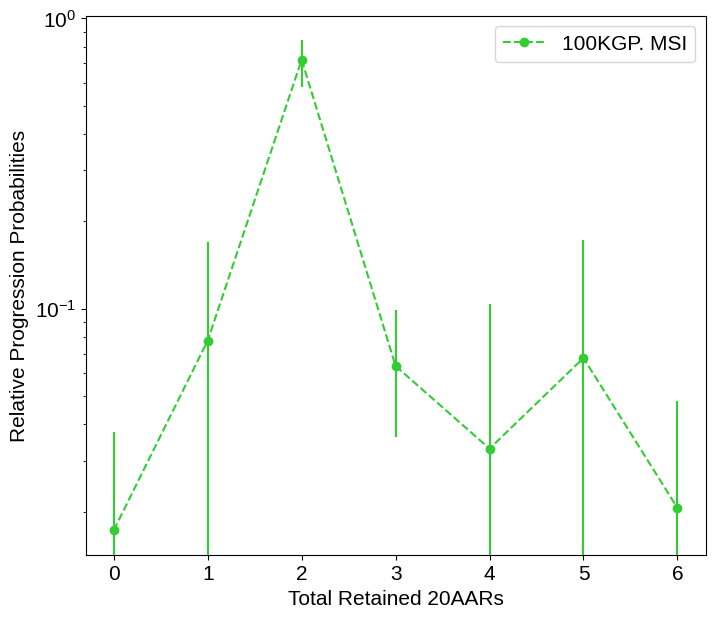

In [8]:
# Bootstrapping of progression probability by 20AAR
px_m,lx_m,hx_m = bootstrap_func_values_ci(df_KGP_MSI, progression_probability_20AARs, 1000, 0.95,null_=null_MSI)

# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_KGP_MSI, max_20AARs, 1000, 0.95,null_=null_MSI)
print('Max 20AARs:',Max,', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_KGP_MSI, mean_20AARs, 1000, 0.95,null_=null_MSI)
print('Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort:',Meanx, ', 95% CI', Mlmx,Mhmx)
print(Meanx,Mlmx,Mhmx)

plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7),px_m,'o--',color='limegreen',label='100KGP. MSI')
plt.vlines(np.arange(7),lx_m,hx_m,color='limegreen')#

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/MSI.svg',dpi=300)

In [9]:
df_KGP_MSI['A']=np.zeros(len(df_KGP_MSI))
df_KGP_MSS['A']=np.ones(len(df_KGP_MSS))
frames = [df_KGP_MSI, df_KGP_MSS]
result = pd.concat(frames)
dif_MSS,cl,ch=bootstrap_func_values_one(result,diff_mean_20AARs, 1000,95, null_1=null_MSS, null_2=null_MSI)
print(r'$\Delta_{MSS-MSI}$, signature corrected=', np.round(dif_MSS,3), cl, ch)
if cl*ch<0:
    print('No significant difference as CI overlap positive and negative values')
else:
    print('Data in acordance with a significant change')


dif_MSS,cl,ch=bootstrap_func_values_one(result,diff_mean_20AARs, 1000,95, null_1=null_MSS, null_2=null_MSS)
print(r'$\Delta_{MSS-MSI}$, NOT signature corrected=', np.round(dif_MSS,3), cl, ch)
if cl*ch<0:
    print('No significant difference as CI overlap positive and negative values')
else:
    print('Data in acordance with a significant change')


$\Delta_{MSS-MSI}$, signature corrected= -0.31 -0.7095426799053278 0.04689734714329093
No significant difference as CI overlap positive and negative values
$\Delta_{MSS-MSI}$, NOT signature corrected= -1.879 -2.5005426502312957 -0.9298181360665102
Data in acordance with a significant change


## 4.2 For POLE

Max 20AARs: [2.484] , 95% CI [2.] [3.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort: [2.22731778] , 95% CI [1.90086013] [2.54009004]


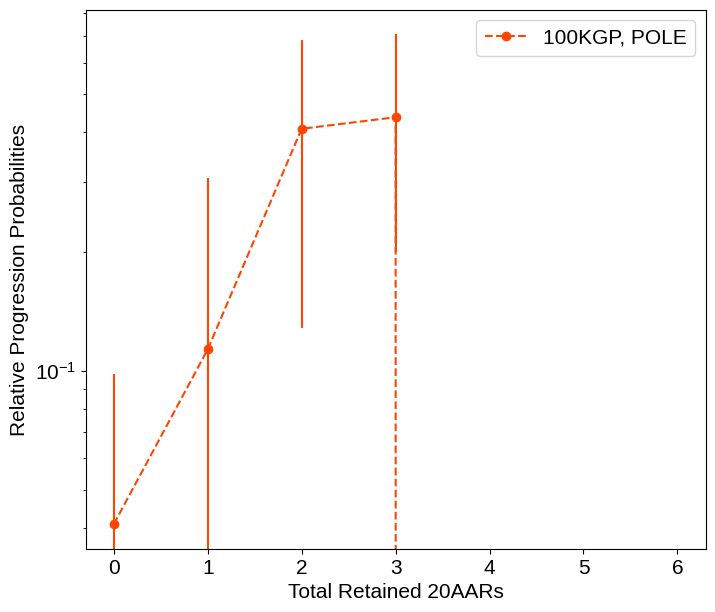

In [10]:
# Bootstrapping of progression probability by 20AAR
px_POLE,lx_POLE,hx_POLE = bootstrap_func_values_ci(df_KGP_POLE, progression_probability_20AARs, 1000, 0.95,null_=null_POLE)

# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_KGP_POLE, max_20AARs, 1000, 0.95,null_=null_POLE)
print('Max 20AARs:',Max,', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_KGP_POLE, mean_20AARs, 1000, 0.95,null_=null_POLE)
print('Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort:',Meanx, ', 95% CI', Mlmx,Mhmx)


plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7),px_POLE,'o--',color='orangered',label='100KGP, POLE')
plt.vlines(np.arange(7),lx_POLE,hx_POLE,color='orangered')#

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/POLE.svg',dpi=300)


In [11]:
df_KGP_POLE['A']=np.zeros(len(df_KGP_POLE))
df_KGP_MSS['A']=np.ones(len(df_KGP_MSS))
frames = [df_KGP_POLE, df_KGP_MSS]
result = pd.concat(frames)
dif_MSS,cl,ch=bootstrap_func_values_one(result,diff_mean_20AARs, 1000,95, null_1=null_MSS, null_2=null_POLE)
print(r'$\Delta_{MSS-POLE}$, signature corrected=', np.round(dif_MSS,3), cl, ch)
if cl*ch<0:
    print('No significant difference as CI overlap positive and negative values')
else:
    print('Data in acordance with a significant change')


dif_MSS,cl,ch=bootstrap_func_values_one(result,diff_mean_20AARs, 1000,95, null_1=null_MSS, null_2=null_MSS)
print(r'$\Delta_{MSS-POLE}$, NOT signature corrected=', np.round(dif_MSS,3), cl, ch)
if cl*ch<0:
    print('No significant difference as CI overlap positive and negative values')
else:
    print('Data in acordance with a significant change')


$\Delta_{MSS-POLE}$, signature corrected= -0.235 -0.6166465265470722 0.1484218158376743
No significant difference as CI overlap positive and negative values
$\Delta_{MSS-POLE}$, NOT signature corrected= -0.341 -0.7907544905747461 0.1465373868194373
No significant difference as CI overlap positive and negative values


## 4.3 Combined

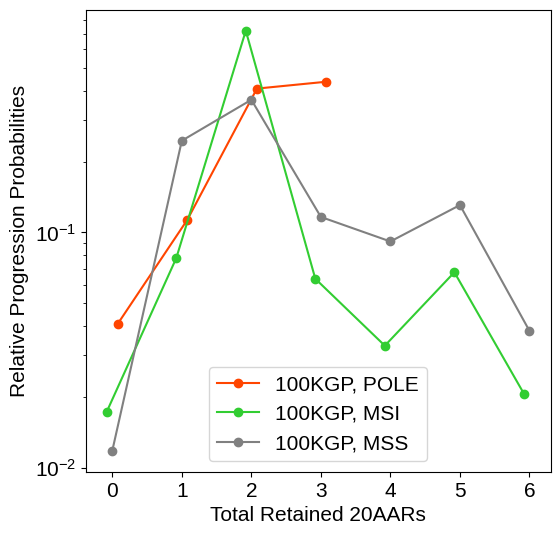

In [12]:
MSS_progression=pd.read_csv(parent_dir+'/Main Analysis/Results/MSS_100KGP_by_20AARs.csv')
px_MSS=np.asarray(MSS_progression['100KGP Progression Probability'])
lx_MSS=np.asarray(MSS_progression['CLow'])

hx_MSS=np.asarray(MSS_progression['CHigh'])

plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(4)+0.08,px_POLE[0:4],'o-',color='orangered',label='100KGP, POLE')
plt.plot(np.arange(7)-0.08,px_m,'o-',color='limegreen',label='100KGP, MSI')
plt.plot(np.arange(7),px_MSS,'o-',color='grey',label='100KGP, MSS')

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/MSI+POLE.svg',dpi=300)


## 4.4 Without signature correction

Max 20AARs: [4.22] , 95% CI [2.] [6.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort: [3.9555655] , 95% CI [3.30858797] [4.45107065]
[3.9555655] [3.30858797] [4.45107065]


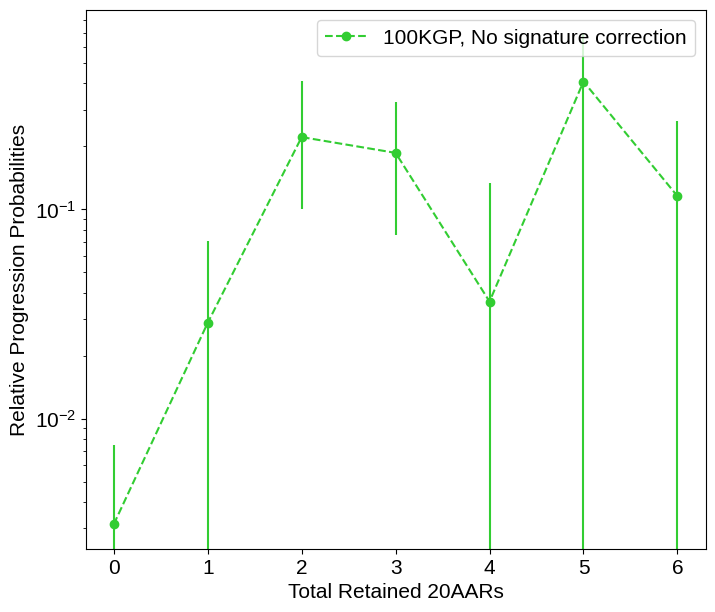

In [13]:
# Bootstrapping of progression probability by 20AAR
px_m,lx_m,hx_m = bootstrap_func_values_ci(df_KGP_MSI, progression_probability_20AARs, 100, 0.95,null_=null_MSS)

# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_KGP_MSI, max_20AARs, 100, 0.95,null_=null_MSS)
print('Max 20AARs:',Max,', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_KGP_MSI, mean_20AARs, 100, 0.95,null_=null_MSS)
print('Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort:',Meanx, ', 95% CI', Mlmx,Mhmx)
print(Meanx,Mlmx,Mhmx)

plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7),px_m,'o--',color='limegreen',label='100KGP, No signature correction')
plt.vlines(np.arange(7),lx_m,hx_m,color='limegreen')#

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/MSI_nocorrection.svg',dpi=300)

Max 20AARs: [2.86] , 95% CI [2.] [3.]
We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability
We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability
Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort: [2.3294024] , 95% CI [1.90305888] [2.70589508]


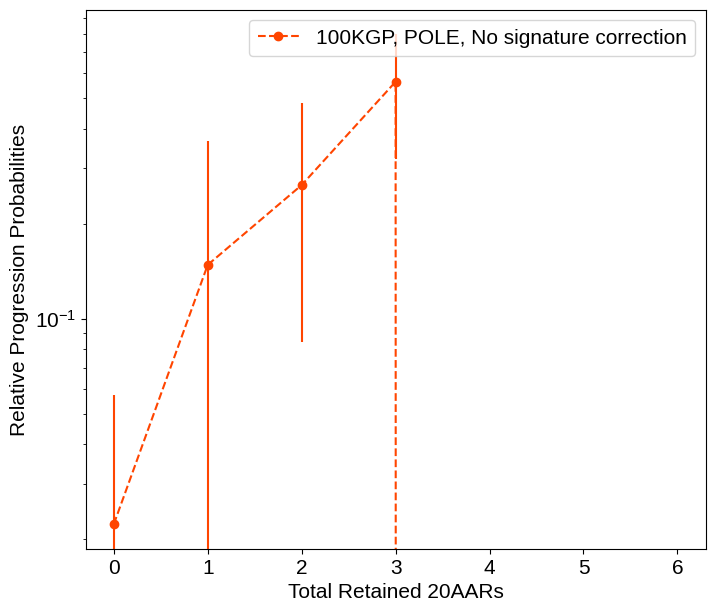

In [14]:
# Bootstrapping of progression probability by 20AAR
px_POLE,lx_POLE,hx_POLE = bootstrap_func_values_ci(df_KGP_POLE, progression_probability_20AARs, 100, 0.95,null_=null_MSS)

# Bootstrapping of max 20AAR
Max,lmx,hmx = bootstrap_func_values_ci(df_KGP_POLE, max_20AARs, 100, 0.95,null_=null_MSS)
print('Max 20AARs:',Max,', 95% CI', lmx,hmx)
print('We reject the Maximal loss implies maximal risk as 0 20AARs is not in the 95% CI for the maximal progression probability')
print('We conclude that data is consistent with Just right as 2 20AAR is in the 95% CI for the maximal progression probability')

# Bootstrapping of  progression-weighted mean number of 20AARs 
Meanx,Mlmx,Mhmx = bootstrap_func_values_ci(df_KGP_POLE, mean_20AARs, 100, 0.95,null_=null_MSS)
print('Progression-weighted mean number of total retained 20AARs in MSS, 100KGP cohort:',Meanx, ', 95% CI', Mlmx,Mhmx)


plt.figure(figsize=(8,7))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(7),px_POLE,'o--',color='orangered',label='100KGP, POLE, No signature correction')
plt.vlines(np.arange(7),lx_POLE,hx_POLE,color='orangered')#

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/POLE_nocorrection.svg',dpi=300)


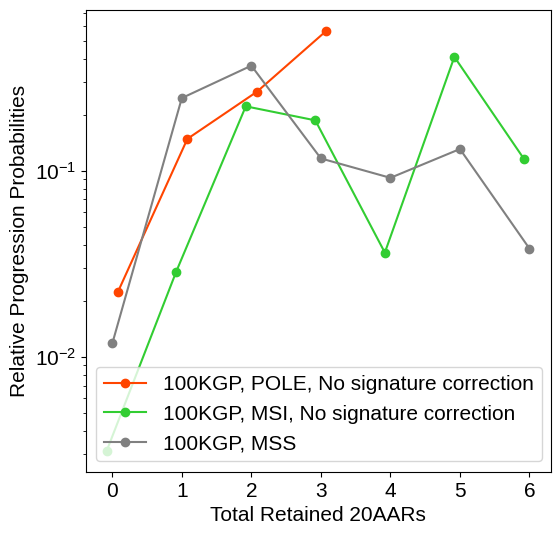

In [15]:
MSS_progression=pd.read_csv(parent_dir+'/Main Analysis/Results/MSS_100KGP_by_20AARs.csv')
px_MSS=np.asarray(MSS_progression['100KGP Progression Probability'])
lx_MSS=np.asarray(MSS_progression['CLow'])

hx_MSS=np.asarray(MSS_progression['CHigh'])

plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'Liberation Sans'

plt.plot(np.arange(4)+0.08,px_POLE[0:4],'o-',color='orangered',label='100KGP, POLE, No signature correction')
plt.plot(np.arange(7)-0.08,px_m,'o-',color='limegreen',label='100KGP, MSI, No signature correction')
plt.plot(np.arange(7),px_MSS,'o-',color='grey',label='100KGP, MSS')

         
plt.legend()
plt.yscale('log')
plt.xlabel('Total Retained 20AARs')
plt.ylabel('Relative Progression Probabilities')
plt.legend()

plt.savefig('Results/MSI+POLE_nocorrection.svg',dpi=300)
